In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# The data

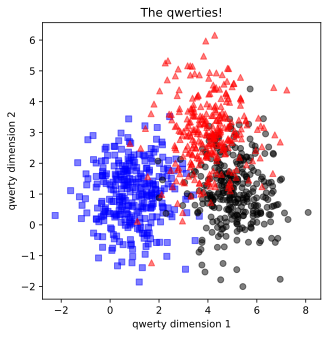

In [2]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [4]:
# how many batches are there?

print(f'There are {len(train_loader)} batches, each with {batchsize} samples.')

There are 50 batches, each with 16 samples.


# The model

In [5]:
# create a class for the model
def createTheQwertyNet(optimizerAlgo, learning_rate):
  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr(torch.optim, optimizerAlgo)
  optimizer = optifun(net.parameters(), lr=learning_rate)

  return net,lossfun,optimizer


In [6]:
# test the model with optimizer type as input

# try 'SGD', 'RMSprop', and 'Adam'
optim = createTheQwertyNet('RMSprop', .01)[2]
optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

# A function that trains the model

In [7]:
def function2trainTheModel(optimizerType, learning_rate):
  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(optimizerType, learning_rate)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [8]:
learning_rates = np.logspace(np.log10(.0001), np.log10(.1), 20)
learning_rates

array([0.0001    , 0.00014384, 0.00020691, 0.00029764, 0.00042813,
       0.00061585, 0.00088587, 0.00127427, 0.00183298, 0.00263665,
       0.00379269, 0.00545559, 0.0078476 , 0.01128838, 0.01623777,
       0.02335721, 0.03359818, 0.0483293 , 0.06951928, 0.1       ])

# Now for the optimizer comparison

In [9]:
# average performance
performance = []
optimizers = ['SGD', 'RMSprop', 'Adam']
test_performances = np.zeros((len(learning_rates), len(optimizers)))

for i, opto in enumerate(optimizers):
  for j, learning_rate in enumerate(learning_rates):
    trainAcc, testAcc, losses, net = function2trainTheModel(opto, learning_rate)

    # store the final results
    train = np.mean(trainAcc[-10:])
    test = np.mean(testAcc[-10:])
    test_performances[j,i] = test

    performance.append( f'{opto}: train {train:.1f}%, test {test:.1f}%' )

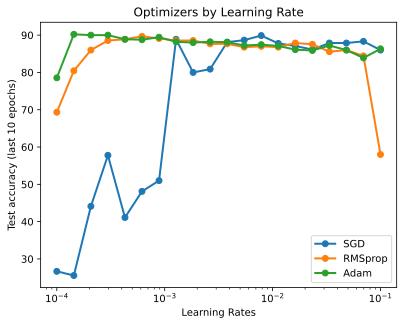

In [10]:
plt.plot(learning_rates, test_performances, "o-", linewidth = 2)
plt.legend(optimizers)
plt.xscale('log')
plt.xlabel('Learning Rates')
plt.ylabel('Test accuracy (last 10 epochs)')
plt.title('Optimizers by Learning Rate')
plt.show()


# Additional explorations

In [11]:
# 1) Accuracy seems to be different between the different qwerties categories. Is this consistent across the optimizers?
#    Or does it seem like some optimizers are better at some categories? How do you interpret your answer, and what does
#    it indicate about metaparameters of DL and their effects on performance?
# 
# 2) The results here indicate that all three optimizers perform roughly equally well, but SGD needs more training. Is 
#    that still the case with a smaller or larger learning rate?
# 
# 3) The method of showing the final performance (printing out a list) is... not very pretty. What kind of visualization
#    do you think would better illustrate the performances across the optimizers? Code it! 
# 